# We Rate Dogs 数据清洗项目 

### 项目背景
目标：清洗 WeRateDogs 推特数据，创建有趣且可靠的分析和可视化。

### 项目数据

#### 1、WeRateDogs的推特档案数据 twitter-archive-enhanced.csv

从包括5000多条推特的基本信息的数据中提取了评分、狗的名字和“地位”（即 doggo、floofer、pupper 和 puppo），只筛选出了 2356 条包含评分的推特数据，形成数据集twitter-archive-enhanced.csv。但提取的评分并不都是正确的，狗的名字和地位 (参见下面更多相关信息) 也有不正确的。如果想用它们进行分析和可视化，需要评估和清洗这些列。

#### 2、通过推特API获取的附加数据 tweet_json.txt

推特API中都可以收集到含有转发数（retweet count）和喜爱数（favorite count）的数据。文件为 txt 格式，每一行为一条独立的 twitter 信息，格式为 JSON。

#### 3、图像预测文件 image-predictions.tsv

通过一个可以对狗狗种类进行分类的神经网络，运行这份推特档案中的所有图像。获取的结果：一份图像预测结果表格，其中包含了预测结果的前三名，推特 ID，图像url以及最可信的预测结果对应的图像编号。

### 关键要点

1、只需要含有图片的原始评级 (不包括转发)。

2、本项目要求评估和清理数据集中的至少 8 个质量问题和至少 2 个整洁度问题。

3、本项目的数据清理应该包括将三个数据片段进行合并。

4、如果分子评级超过分母评级，不需要进行清洗。

5、不必收集 2017 年 8 月 1 日之后的数据。

### 收集数据

In [1]:
#导入本项目需要的库
import pandas as pd
import numpy as np
import requests as req
import simplejson as json
import re
import os

In [2]:
df_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#从tweet_json.txt文件转读取Json格式的数据
tweet_json = []
with open('tweet_json.txt', 'r') as f:
    for line in f.readlines():
        x = json.loads(line)
        tweet_json.append(x)
print(tweet_json)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
df_json = pd.DataFrame(tweet_json)

In [5]:
#从url下载image_prediction数据
folder_name = 'image_prediction'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'
response = req.get(url)
response

with open(os.path.join(folder_name,
                      url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [6]:
df_image_pre = pd.read_csv('image_prediction/image-predictions.tsv', sep='\t')

### 评估数据

#### df_enhanced数据集

1、expanded_urls有数据缺失59个；

2、expanded_urls有数据重复137个；

3、部分expanded_urls有多个值；

4、部分expanded_urls中不含id信息，无法提取id;

5、部分从expanded_urls中的id与tweet_id不符，说明是转发；

6、部分expanded_urls中无数据无图片信息，说明不含图片；

7、name列有一些是a、the、an等；

8、有一些分母不为10，观察对应的text中的信息，有一些是提取错误，有一些是评价了多条狗狗；

9、doggo、floofer、pupper、puppo应该作为一列出现。


#### df_json数据集

1、含有很多信息，保留favorite_count和retweet_count数据即可。

#### df_image_pre数据集

1、jpg_url有数据重复66个；

2、在数据整合阶段，预测结果不是狗狗的的数据不使用。

In [7]:
#先评估df_enhanced数据集
df_enhanced.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
df_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
#expanded_urls为空的数量
df_enhanced[df_enhanced['expanded_urls'].isnull()].count()

tweet_id                      59
in_reply_to_status_id         55
in_reply_to_user_id           55
timestamp                     59
source                        59
text                          59
retweeted_status_id            1
retweeted_status_user_id       1
retweeted_status_timestamp     1
expanded_urls                  0
rating_numerator              59
rating_denominator            59
name                          59
doggo                         59
floofer                       59
pupper                        59
puppo                         59
dtype: int64

In [11]:
#tweet_id值重复的数量
sum(df_enhanced['tweet_id'].duplicated())

0

In [12]:
#expanded_urls值重复的数量
sum(df_enhanced['expanded_urls'].duplicated())

137

In [13]:
df_enhanced['expanded_urls'].value_counts()

https://twitter.com/dog_rates/status/694669722378485760/photo/1,https://twitter.com/dog_rates/status/694669722378485760/photo/1                                                                                                                                                                        2
https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://twitter.com/dog_rates/status/873213775632977920/photo/1                                                                                                                2
https://twitter.com/dog_rates/status/820749716845686786/photo/1,https://twitter.com/dog_rates/status/820749716845686786/photo/1                                                                                                                                                                        2
https://twitter.com/dog_rates/status/667182792070062081/photo/1                                              

In [14]:
#观察评分分母不为10的text信息
pd.set_option('display.max_colwidth',100)
df_enhanced[df_enhanced['rating_denominator'] != 10].count()

tweet_id                      23
in_reply_to_status_id          5
in_reply_to_user_id            5
timestamp                     23
source                        23
text                          23
retweeted_status_id            1
retweeted_status_user_id       1
retweeted_status_timestamp     1
expanded_urls                 19
rating_numerator              23
rating_denominator            23
name                          23
doggo                         23
floofer                       23
pupper                        23
puppo                         23
dtype: int64

In [15]:
df_enhanced[df_enhanced['rating_denominator'] != 10][['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clickin...,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search ...",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our se...",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at onc...,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 ht...,50,50


In [16]:
pd.set_option('display.max_colwidth',50)
df_enhanced.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2122,670403879788544000,NaN,NaN,2015-11-28 00:48:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Nigel. He accidentally popped his ball...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670403879...,10,10,Nigel,None,None,None,None
2088,670792680469889025,NaN,NaN,2015-11-29 02:33:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Antony. He's a Sheraton Tetrahedron. S...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670792680...,7,10,Antony,None,None,None,None
162,860524505164394496,NaN,NaN,2017-05-05 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Carl. He likes to dance. Doesn't care ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/860524505...,13,10,Carl,None,None,None,None
808,771770456517009408,NaN,NaN,2016-09-02 18:03:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Davey. He'll have your daughter home b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/771770456...,11,10,Davey,None,None,None,None
1309,707059547140169728,NaN,NaN,2016-03-08 04:25:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Cupcake. She's an Icelandic Dippe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707059547...,11,10,Cupcake,None,None,None,None


In [17]:
#评估df_json数据集
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 31 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2352 non-null object
display_text_range               2352 non-null object
entities                         2352 non-null object
extended_entities                2073 non-null object
favorite_count                   2352 non-null int64
favorited                        2352 non-null bool
full_text                        2352 non-null object
geo                              0 non-null object
id                               2352 non-null int64
id_str                           2352 non-null object
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null obj

In [18]:
df_json.describe()

,favorite_count,id,in_reply_to_status_id,in_reply_to_user_id,quoted_status_id,retweet_count
count,2352.000000,2.352000e+03,7.800000e+01,7.800000e+01,2.900000e+01,2352.000000
mean,8109.198980,7.425913e+17,7.455079e+17,2.014171e+16,8.162686e+17,3134.932398
std,11980.795669,6.846210e+16,7.582492e+16,1.252797e+17,6.164161e+16,5237.846296
min,0.000000,6.660209e+17,6.658147e+17,1.185634e+07,6.721083e+17,0.000000
25%,1417.000000,6.783949e+17,6.757419e+17,3.086374e+08,7.888183e+17,618.000000
50%,3596.500000,7.193536e+17,7.038708e+17,4.196984e+09,8.340867e+17,1456.500000
75%,10118.000000,7.991219e+17,8.257804e+17,4.196984e+09,8.664587e+17,3628.750000
max,132318.000000,8.924206e+17,8.862664e+17,8.405479e+17,8.860534e+17,79116.000000


In [19]:
df_json.sample(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
1449,None,None,Fri Feb 05 15:27:17 +0000 2016,"[0, 108]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 695629772496465921, 'id_str'...",4992,False,Meet Calvin. He's proof that degrees mean abso...,None,...,False,NaN,NaN,NaN,2364,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1308,None,None,Tue Mar 08 01:25:10 +0000 2016,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 707014226158751746, 'id_str'...",2496,False,This is Ellie. She requests to be carried arou...,None,...,False,NaN,NaN,NaN,659,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
864,None,None,Sat Aug 06 02:27:27 +0000 2016,"[0, 126]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 685325091882799104, 'id_str'...",0,False,"RT @dog_rates: ""Tristan do not speak to me wit...",None,...,False,NaN,NaN,NaN,4511,False,{'created_at': 'Fri Jan 08 05:00:14 +0000 2016...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1132,None,None,Fri May 06 00:53:27 +0000 2016,"[0, 113]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 728387158260723712, 'id_str'...",3977,False,"This is Enchilada (yes, that's her real name)....",None,...,False,NaN,NaN,NaN,1071,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2299,None,None,Wed Nov 18 15:07:24 +0000 2015,"[0, 105]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666996118815817730, 'id_str'...",257,False,This is Carll. He wants to be a donkey. But al...,None,...,False,NaN,NaN,NaN,101,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [20]:
#id值重复的数量
sum(df_json['id'].duplicated())

0

In [21]:
#点赞数或转发数为0的数据
df_json[(df_json['favorite_count'] == 0) | (df_json['retweet_count'] == 0)].count()

contributors                       0
coordinates                        0
created_at                       178
display_text_range               178
entities                         178
extended_entities                 79
favorite_count                   178
favorited                        178
full_text                        178
geo                                0
id                               178
id_str                           178
in_reply_to_screen_name            1
in_reply_to_status_id              1
in_reply_to_status_id_str          1
in_reply_to_user_id                1
in_reply_to_user_id_str            1
is_quote_status                  178
lang                             178
place                              0
possibly_sensitive                94
possibly_sensitive_appealable     94
quoted_status                      0
quoted_status_id                   1
quoted_status_id_str               1
retweet_count                    178
retweeted                        178
r

In [22]:
df_json[(df_json['favorite_count'] == 0) | (df_json['retweet_count'] == 0)]

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
31,None,None,Sat Jul 15 02:45:48 +0000 2017,"[0, 50]","{'hashtags': [{'text': 'BATP', 'indices': [21,...",NaN,0,False,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,None,...,False,NaN,8.860534e+17,886053434075471873,106,False,{'created_at': 'Sat Jul 15 02:44:07 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
35,None,None,Thu Jul 13 01:35:06 +0000 2017,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 830583314243268608, 'id_str'...",0,False,RT @dog_rates: This is Lilly. She just paralle...,None,...,False,NaN,NaN,NaN,19188,False,{'created_at': 'Sun Feb 12 01:04:29 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
67,None,None,Mon Jun 26 00:13:58 +0000 2017,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: This is Emmy. She was adopted t...,None,...,NaN,NaN,NaN,NaN,7118,False,{'created_at': 'Fri Jun 23 01:10:23 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
72,None,None,Sat Jun 24 00:09:53 +0000 2017,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: Meet Shadow. In an attempt to r...,None,...,NaN,NaN,NaN,NaN,1338,False,{'created_at': 'Fri Jun 23 16:00:04 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
73,None,None,Fri Jun 23 18:17:33 +0000 2017,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: Meet Terrance. He's being yelle...,None,...,NaN,NaN,NaN,NaN,6925,False,{'created_at': 'Tue Nov 24 03:51:38 +0000 2015...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
77,None,None,Wed Jun 21 19:36:23 +0000 2017,"[0, 122]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 876850756556607488, 'id_str'...",0,False,RT @rachel2195: @dog_rates the boyfriend and h...,None,...,False,NaN,NaN,NaN,82,False,{'created_at': 'Mon Jun 19 17:14:49 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
90,None,None,Tue Jun 13 01:14:41 +0000 2017,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: This is Coco. At first I though...,None,...,NaN,NaN,NaN,NaN,15442,False,{'created_at': 'Sun May 21 16:48:45 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
94,None,None,Sun Jun 11 00:25:14 +0000 2017,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 868880391209275392, 'id_str'...",0,False,RT @dog_rates: This is Walter. He won't start ...,None,...,False,NaN,NaN,NaN,12435,False,{'created_at': 'Sun May 28 17:23:24 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
96,None,None,Sat Jun 10 00:35:19 +0000 2017,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: This is Sierra. She's one preci...,None,...,NaN,NaN,NaN,NaN,1656,False,{'created_at': 'Fri Jun 09 16:22:42 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
100,None,None,Thu Jun 08 04:17:07 +0000 2017,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @loganamnosis: Penelope here is doing me qu...,None,...,NaN,NaN,NaN,NaN,31,False,{'created_at': 'Thu Jun 08 03:32:35 +0000 2017.

In [23]:
#评估df_image_pre数据集
df_image_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
df_image_pre.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [25]:
df_image_pre.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1535,790337589677002753,https://pbs.twimg.com/media/CvfX2AnWYAAQTay.jpg,1,Pembroke,0.658808,True,Cardigan,0.153096,True,toy_terrier,0.102299,True
1432,773308824254029826,https://pbs.twimg.com/media/CrtYRMEWIAAUkCl.jpg,1,shopping_cart,0.572349,False,Labrador_retriever,0.151406,True,shopping_basket,0.107102,False
337,672231046314901505,https://pbs.twimg.com/media/CVQ-kfWWoAAXV15.jpg,1,killer_whale,0.823919,False,grey_whale,0.036601,False,hammerhead,0.029522,False
691,684200372118904832,https://pbs.twimg.com/media/CX7EkuHWkAESLZk.jpg,1,llama,0.681347,False,ram,0.120142,False,hog,0.043686,False
1492,782969140009107456,https://pbs.twimg.com/media/Ct2qO5PXEAE6eB0.jpg,1,seat_belt,0.474292,False,golden_retriever,0.171393,True,Labrador_retriever,0.110592,True


In [26]:
#tweet_id值重复的数量
sum(df_image_pre['tweet_id'].duplicated())

0

In [27]:
#jpg_url重复的数量
sum(df_image_pre['jpg_url'].duplicated())

66

In [28]:
df_image_pre['jpg_url'].value_counts()

https://pbs.twimg.com/ext_tw_video_thumb/817423809049493505/pu/img/5OFW0yueFu9oTUiQ.jpg    2
https://pbs.twimg.com/media/Cwx99rpW8AMk_Ie.jpg                                            2
https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg                                            2
https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg                                            2
https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg    2
https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg                                2
https://pbs.twimg.com/media/CwS4aqZXUAAe3IO.jpg                                            2
https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg                                            2
https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg                                            2
https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg                       

#### 质量问题

#### df_enhanced数据集

1、应该删除expanded_urls缺失的数据，完整性问题；

2、应该删除expanded_urls重复的数据，完整性问题；

3、应该删除 2017 年 8 月 1 日之后的数据，完整性问题；

4、应该仅保留含有图片的原始评级 (不包括转发），完整性问题；

5、应该将expanded_urls有多个值的数据更改为1个，有效性问题；

6、应该删除无法从expanded_urls中提取id的数据，有效性问题；

7、应该从text中提取评分值，有两条数据评分分别为420/10和1776/10，将其作为异常值处理，删除，有效性问题；

8、修改提取的评分与rating_numerator和rating_denominator不符的值，准确性问题；

9、评分分母不为10的改为10，多条狗狗一起的评分应该取平均值，一致性问题；

10、修改name列，保留名字，其余的内容为a, the, an的内容删除，准确性问题；

#### df_json数据集

11、应该将favorite_count, retweet_count为0的数据作为异常值处理，有效性问题；


#### 整洁度问题

1、df_enhanced数据集中从text中提取狗狗的种类信息，将doggo, floofer, puppo, pupper四列转换为一列status;

2、将三个数据片段合成一个数据集。

### 清理数据

In [29]:
#备份数据
df_enhanced_clean = df_enhanced.copy()
df_json_clean = df_json.copy()
df_image_pre_clean = df_image_pre.copy()

#### 缺失数据

#### df_enhanced：
expanded_url缺少记录59条。

##### define

保留enhanced数据集中的tweet_id，timestamp，text，expanded_urls，rating_numerator，rating_denominator，name，doggo, floofer, pupper, puppo列，运用notnull()函数保留成为新的DataFrame。

##### code

In [30]:
df_enhanced_clean = df_enhanced_clean[['tweet_id','timestamp','text','rating_numerator','rating_denominator','expanded_urls','name','doggo','floofer','pupper','puppo']]
df_enhanced_clean = df_enhanced_clean[df_enhanced_clean['expanded_urls'].notnull()]

##### test

In [31]:
df_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2297 non-null int64
timestamp             2297 non-null object
text                  2297 non-null object
rating_numerator      2297 non-null int64
rating_denominator    2297 non-null int64
expanded_urls         2297 non-null object
name                  2297 non-null object
doggo                 2297 non-null object
floofer               2297 non-null object
pupper                2297 non-null object
puppo                 2297 non-null object
dtypes: int64(3), object(8)
memory usage: 215.3+ KB


#### 整洁度问题

#### df_enhanced：
从text中提取狗狗的种类信息，将doggo, floofer, puppo, pupper四列转换为一列status。

##### define

从text中提取狗狗的地位信息，将doggo, floofer, puppo, pupper四列转换为一列status，拥有多种地位的狗狗标记为multiple。

##### code

In [32]:
#从text中提取doggo，floofer,pupper,puppo数据
df_enhanced_clean['doggo'] = df_enhanced_clean['text'].str.extract('\s([Dd]oggo).*')
df_enhanced_clean['floofer'] = df_enhanced_clean['text'].str.extract('\s([Ff]loof(er)?).*')
df_enhanced_clean['pupper'] = df_enhanced_clean['text'].str.extract('\s([Pp]upper).*')
df_enhanced_clean['puppo'] = df_enhanced_clean['text'].str.extract('\s([Pp]uppo).*')

In [33]:
#用空字符串替代空值
df_enhanced_clean['doggo'] = df_enhanced_clean['doggo'].fillna('')
df_enhanced_clean['floofer'] = df_enhanced_clean['floofer'].fillna('')
df_enhanced_clean['pupper'] = df_enhanced_clean['pupper'].fillna('')
df_enhanced_clean['puppo'] = df_enhanced_clean['puppo'].fillna('')

In [34]:
#doggo，floofer,pupper,puppo四列相加，得到status列
df_enhanced_clean['status'] = df_enhanced_clean['doggo'] + df_enhanced_clean['floofer'] + df_enhanced_clean['pupper'] + df_enhanced_clean['puppo']

In [35]:
#status列的值统一为小写，同时floof和floofer统一为floofer
df_enhanced_clean['status'] = df_enhanced_clean['status'].str.lower()
df_enhanced_clean['status'] = df_enhanced_clean['status'].str.replace('floofer','floof')
df_enhanced_clean['status'] = df_enhanced_clean['status'].str.replace('floof','floofer')

In [36]:
df_enhanced_clean['status'].value_counts()

                 1880
pupper            260
doggo              85
puppo              31
floofer            27
doggopupper         8
doggofloofer        3
doggopuppo          2
flooferpupper       1
Name: status, dtype: int64

In [37]:
df_enhanced_clean['status'] = df_enhanced_clean['status'].astype(str)

In [38]:
#将拥有多重身份的狗狗的status标记为multiple
df_enhanced_clean['status'] = df_enhanced_clean['status'].str.replace('doggopupper','multiple')
df_enhanced_clean['status'] = df_enhanced_clean['status'].str.replace('doggopuppo','multiple')
df_enhanced_clean['status'] = df_enhanced_clean['status'].str.replace('doggofloofer','multiple')
df_enhanced_clean['status'] = df_enhanced_clean['status'].str.replace('flooferpupper','multiple')

##### test

In [39]:
df_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2297 non-null int64
timestamp             2297 non-null object
text                  2297 non-null object
rating_numerator      2297 non-null int64
rating_denominator    2297 non-null int64
expanded_urls         2297 non-null object
name                  2297 non-null object
doggo                 2297 non-null object
floofer               2297 non-null object
pupper                2297 non-null object
puppo                 2297 non-null object
status                2297 non-null object
dtypes: int64(3), object(9)
memory usage: 233.3+ KB


In [40]:
df_enhanced_clean['status'].value_counts()

            1880
pupper       260
doggo         85
puppo         31
floofer       27
multiple      14
Name: status, dtype: int64

In [41]:
#删除doggo，floofer,pupper,puppo四列
df_enhanced_clean.drop(['doggo','floofer','pupper','puppo'], axis = 1, inplace = True)

#### 质量问题

#### df_enhanced：
1、expanded_url有重复记录；

2、有部分expanded_urls中无法提取id，有部分提取id与tweet_id不同，不是原始评级；

##### define

从expanded_urls中提取id构建新的列id_url，将tweet_id转换为str格式，删除tweet_id与id_url不等的数据，测试完成后删除id_url列成为新的DataFrame。

##### code

In [42]:
#从expanded_urls中提取id为id_url，仅保留tweet_id与id_url一致的数据
df_enhanced_clean['id_url'] = df_enhanced_clean['expanded_urls'].str.extract('status/(\d+)')
df_enhanced_clean['tweet_id'] = df_enhanced_clean['tweet_id'].astype(str)
df_enhanced_clean = df_enhanced_clean[df_enhanced_clean['tweet_id'] == df_enhanced_clean['id_url']]

##### test

In [43]:
#检测是否含有tweet_id与id_url值不同的数据
df_enhanced_clean[df_enhanced_clean['tweet_id'] != df_enhanced_clean['id_url']]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,expanded_urls,name,status,id_url


In [44]:
#检测是否有id_url为空值
df_enhanced_clean[df_enhanced_clean['id_url'].isnull()]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,expanded_urls,name,status,id_url


In [45]:
#检测expanded_urls重复的数量
sum(df_enhanced_clean['expanded_urls'].duplicated())

0

In [46]:
df_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              1994 non-null object
timestamp             1994 non-null object
text                  1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
expanded_urls         1994 non-null object
name                  1994 non-null object
status                1994 non-null object
id_url                1994 non-null object
dtypes: int64(2), object(7)
memory usage: 155.8+ KB


In [47]:
#删除id_url列
df_enhanced_clean.drop('id_url', axis = 1, inplace = True)

#### 质量问题

#### df_enhanced：应该删除 2017 年 8 月 1 日之后的数据；

##### define

将timestamp转换为datetime格式，删除2017年8月1日之后的数据，保留成为新的DataFrame。

##### code

In [48]:
df_enhanced_clean['timestamp'] = pd.to_datetime(df_enhanced_clean['timestamp'],format='%Y-%m-%d %H:%M:%S')
df_enhanced_clean = df_enhanced_clean[df_enhanced_clean['timestamp'] < '2017-08-02 00:00:00']

##### test

In [49]:
#检测2017年8月1日后的数据
df_enhanced_clean[df_enhanced_clean['timestamp'] >= '2017-08-02 00:00:00']

,tweet_id,timestamp,text,rating_numerator,rating_denominator,expanded_urls,name,status


In [50]:
df_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              1994 non-null object
timestamp             1994 non-null datetime64[ns]
text                  1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
expanded_urls         1994 non-null object
name                  1994 non-null object
status                1994 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 140.2+ KB


#### 质量问题

#### df_enhanced:
1、应该将expanded_urls有多个值的数据更改为1个；

2、应该仅保留含有图片的原始评级数据；

##### define

运用正则表达式 'https://twitter.com/dog_rates/status/\d+/photo/\d' 匹配仅含有图片的原始评级数据，同时提取满足此表达式的字符作为对应的expanded_urls值，同时解决有多个值的情况，形成新的DataFrame。

##### code

In [51]:
#从expanded_urls中提取含有图片的数据，作为新的expanded_urls值，保留不为空值的数据为新的DataFrame。
df_enhanced_clean['expanded_urls'] = df_enhanced_clean['expanded_urls'].str.extract('(https://twitter.com/dog_rates/status/\d+/photo/\d)')
df_enhanced_clean = df_enhanced_clean[df_enhanced_clean['expanded_urls'].notnull()]

#### test

In [52]:
pd.set_option('display.max_colwidth',100)
df_enhanced_clean['expanded_urls'].sample(5)

1595    https://twitter.com/dog_rates/status/686358356425093120/photo/1
1857    https://twitter.com/dog_rates/status/675517828909424640/photo/1
2174    https://twitter.com/dog_rates/status/669216679721873412/photo/1
441     https://twitter.com/dog_rates/status/819711362133872643/photo/1
509     https://twitter.com/dog_rates/status/812466873996607488/photo/1
Name: expanded_urls, dtype: object

In [53]:
#检测获取的新的expanded_urls的长度，评估是否符合要求
len('https://twitter.com/dog_rates/status/705591895322394625/photo/1')

63

In [54]:
df_enhanced_clean['expanded_urls'].map(len).value_counts()

63    1920
Name: expanded_urls, dtype: int64

In [55]:
df_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              1920 non-null object
timestamp             1920 non-null datetime64[ns]
text                  1920 non-null object
rating_numerator      1920 non-null int64
rating_denominator    1920 non-null int64
expanded_urls         1920 non-null object
name                  1920 non-null object
status                1920 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 135.0+ KB


In [56]:
pd.set_option('display.max_colwidth',50)

#### 质量问题

#### df_enhanced：
1、text中的评分与rating_numerator和rating_denominator的值不符；

2、有一些狗狗的评分分母不为10；

3、狗狗评分有异常值；

##### define

运用正则表达式从text列中提取评分值，构成text_numerator和text_denominator列，与rating_numerator和rating_denominator比较，修改不同的值。

分母不为10的改为10，多条狗狗一起的评分取平均值。

删除评分的异常值。

##### code

In [57]:
#从text列中提取评分值，构成text_numerator和text_denominator列,将提取的出值转换为float格式
df_enhanced_clean[['text']] = df_enhanced_clean[['text']].astype(str)
df_enhanced_clean['text_numerator'] = df_enhanced_clean['text'].str.extract('(\d+)/')
df_enhanced_clean['text_numerator'] = df_enhanced_clean['text'].str.extract('(\d+(\.\d+)?)/')
df_enhanced_clean['text_denominator'] = df_enhanced_clean['text'].str.extract('/(\d+)')
df_enhanced_clean['text_numerator'] = df_enhanced_clean['text_numerator'].astype(float)
df_enhanced_clean['text_denominator'] = df_enhanced_clean['text_denominator'].astype(float)

In [58]:
#从text中提取的分子与给出的分子不同的数据
df_enhanced_clean[df_enhanced_clean['rating_numerator'] != df_enhanced_clean['text_numerator']].count()

tweet_id              4
timestamp             4
text                  4
rating_numerator      4
rating_denominator    4
expanded_urls         4
name                  4
status                4
text_numerator        4
text_denominator      4
dtype: int64

In [59]:
df_enhanced_clean[df_enhanced_clean['rating_numerator'] != df_enhanced_clean['text_numerator']]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,expanded_urls,name,status,text_numerator,text_denominator
45,883482846933004288,2017-07-08 00:28:19,This is Bella. She hopes her smile made you sm...,5,10,https://twitter.com/dog_rates/status/883482846...,Bella,,13.50,10.0
695,786709082849828864,2016-10-13 23:23:56,"This is Logan, the Chow who lived. He solemnly...",75,10,https://twitter.com/dog_rates/status/786709082...,Logan,,9.75,10.0
763,778027034220126208,2016-09-20 00:24:34,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10,https://twitter.com/dog_rates/status/778027034...,Sophie,pupper,11.27,10.0
1712,680494726643068929,2015-12-25 21:06:00,Here we have uncovered an entire battalion of ...,26,10,https://twitter.com/dog_rates/status/680494726...,None,pupper,11.26,10.0


In [60]:
#用从text中提取的text_numerator替代rating_numerator
df_enhanced_clean['rating_numerator'] = df_enhanced_clean['text_numerator']

In [61]:
#从text中提取的分母与给出的分母不同的数据
df_enhanced_clean[df_enhanced_clean['rating_denominator'] != df_enhanced_clean['text_denominator']]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,expanded_urls,name,status,text_numerator,text_denominator


In [62]:
#给出分母不为10的数量
df_enhanced_clean[df_enhanced_clean['rating_denominator'] != 10].count()

tweet_id              17
timestamp             17
text                  17
rating_numerator      17
rating_denominator    17
expanded_urls         17
name                  17
status                17
text_numerator        17
text_denominator      17
dtype: int64

In [63]:
#给出分母不为10的数据的tweet_id,text,rating_numerator,rating_denominator信息
pd.set_option('display.max_colwidth',150)
df_enhanced_clean[df_enhanced_clean['rating_denominator'] != 10][['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t ...,24.0,7
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50


In [64]:
#多条狗狗一起的评分取平均值。
df_enhanced_clean.loc[[433,1120,1202,1228,1254,1274,1351,1433,1634,1635,1779,1843],'rating_numerator'] = [12,12,10,11,10,9,12,11,11,11,12,11]
df_enhanced_clean.loc[[433,1120,1202,1228,1254,1274,1351,1433,1634,1635,1779,1843],'rating_denominator'] = [10,10,10,10,10,10,10,10,10,10,10,10]

In [65]:
#数据提取错误的重新提取。
df_enhanced_clean.loc[[1068,1165,1662,2335], 'rating_numerator'] = [14,13,10,9]
df_enhanced_clean.loc[[1068,1165,1662,2335], 'rating_denominator'] = [10,10,10,10]

In [66]:
#删除无法提取评分的数据。
df_enhanced_clean.drop(516, inplace=True)

In [67]:
df_enhanced_clean[df_enhanced_clean['rating_denominator'] != 10][['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator


In [68]:
#寻找异常值。
df_enhanced_clean.describe()

,rating_numerator,rating_denominator,text_numerator,text_denominator
count,1919.000000,1919.0,1919.000000,1919.000000
mean,11.639281,10.0,12.162991,10.481501
std,41.424521,0.0,42.127917,6.747382
min,0.000000,10.0,0.000000,2.000000
25%,10.000000,10.0,10.000000,10.000000
50%,11.000000,10.0,11.000000,10.000000
75%,12.000000,10.0,12.000000,10.000000
max,1776.000000,10.0,1776.000000,170.000000


In [69]:
df_enhanced_clean[(df_enhanced_clean['rating_numerator'] >= 20)| (df_enhanced_clean['rating_numerator'] == 0)]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,expanded_urls,name,status,text_numerator,text_denominator
315,835152434251116546,2017-02-24 15:40:31,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0.0,10,https://twitter.com/dog_rates/status/835152434251116546/photo/1,None,,0.0,10.0
979,749981277374128128,2016-07-04 15:00:45,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776.0,10,https://twitter.com/dog_rates/status/749981277374128128/photo/1,Atticus,,1776.0,10.0
1016,746906459439529985,2016-06-26 03:22:31,"PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",0.0,10,https://twitter.com/dog_rates/status/746906459439529985/photo/1,None,,0.0,10.0
2074,670842764863651840,2015-11-29 05:52:33,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420.0,10,https://twitter.com/dog_rates/status/670842764863651840/photo/1,None,,420.0,10.0


In [70]:
#删除异常值。
df_enhanced_clean.drop([979,2074], inplace = True)

##### test

In [71]:
df_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1917 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              1917 non-null object
timestamp             1917 non-null datetime64[ns]
text                  1917 non-null object
rating_numerator      1917 non-null float64
rating_denominator    1917 non-null int64
expanded_urls         1917 non-null object
name                  1917 non-null object
status                1917 non-null object
text_numerator        1917 non-null float64
text_denominator      1917 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 164.7+ KB


In [72]:
df_enhanced_clean.describe()

,rating_numerator,rating_denominator,text_numerator,text_denominator
count,1917.000000,1917.0,1917.000000,1917.000000
mean,10.505884,10.0,11.030141,10.482003
std,2.177043,0.0,8.047361,6.750884
min,0.000000,10.0,0.000000,2.000000
25%,10.000000,10.0,10.000000,10.000000
50%,11.000000,10.0,11.000000,10.000000
75%,12.000000,10.0,12.000000,10.000000
max,14.000000,10.0,204.000000,170.000000


In [73]:
df_enhanced_clean[df_enhanced_clean['rating_denominator'] != 10].count()

tweet_id              0
timestamp             0
text                  0
rating_numerator      0
rating_denominator    0
expanded_urls         0
name                  0
status                0
text_numerator        0
text_denominator      0
dtype: int64

In [74]:
#删除辅助列text_numerator，text_denominator。
df_enhanced_clean.drop(['text_numerator','text_denominator'], axis = 1, inplace = True)

#### 质量问题

#### df_enhanced：name列有些数据没有，有一些内容为a, the, an等。

##### define

从text中用正则表达式提名字，将a、the、an等内容删除。

##### code

In [75]:
df_enhanced_clean[['text','name']]

,text,name
0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",Tilly
2,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie
3,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,Darla
4,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",Franklin
5,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https:/...,None
6,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H htt...,Jax
7,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,None
8,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,Zoey
9,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co...,Cassie


In [76]:
#从text中提取名字，有如下几种模式，This is XXX, Meet XXX, ...name is XXX, ...named XXX, say hello to XXX
df_enhanced_clean['text_name1'] = df_enhanced_clean['text'].str.extract('This is ([A-Z][a-z]+)')
df_enhanced_clean['text_name2'] = df_enhanced_clean['text'].str.extract('Meet ([A-Z][a-z]+)')
df_enhanced_clean['text_name3'] = df_enhanced_clean['text'].str.extract('name is ([A-Z][a-z]+)')
df_enhanced_clean['text_name4'] = df_enhanced_clean['text'].str.extract('named ([A-Z][a-z]+)')
df_enhanced_clean['text_name5'] = df_enhanced_clean['text'].str.extract('[Ss]ay hello to ([A-Z][a-z]+)')

In [77]:
#将空值用空字符串替代。
df_enhanced_clean['text_name1'].fillna('',inplace = True)
df_enhanced_clean['text_name2'].fillna('',inplace = True)
df_enhanced_clean['text_name3'].fillna('',inplace = True)
df_enhanced_clean['text_name4'].fillna('',inplace = True)
df_enhanced_clean['text_name5'].fillna('',inplace = True)

In [78]:
#相加构成从text中提取出的名字text_name。
df_enhanced_clean['text_name'] = df_enhanced_clean['text_name1'] + df_enhanced_clean['text_name2'] + df_enhanced_clean['text_name3'] + df_enhanced_clean['text_name4'] + df_enhanced_clean['text_name5']

In [79]:
#用提取的text_name替代name。
df_enhanced_clean['name'] = df_enhanced_clean['text_name']

##### test

In [80]:
df_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1917 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id              1917 non-null object
timestamp             1917 non-null datetime64[ns]
text                  1917 non-null object
rating_numerator      1917 non-null float64
rating_denominator    1917 non-null int64
expanded_urls         1917 non-null object
name                  1917 non-null object
status                1917 non-null object
text_name1            1917 non-null object
text_name2            1917 non-null object
text_name3            1917 non-null object
text_name4            1917 non-null object
text_name5            1917 non-null object
text_name             1917 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(11)
memory usage: 224.6+ KB


In [81]:
df_enhanced_clean['name'].value_counts()

             578
Charlie       11
Lucy          10
Cooper        10
Oliver         9
Penny          9
Tucker         9
Winston        8
Sadie          8
Toby           7
Daisy          7
Lola           7
Jax            6
Bella          6
Bo             6
Koda           6
Stanley        6
Louis          5
Bailey         5
Chester        5
Oscar          5
Zoey           5
Cassie         4
Gary           4
Chip           4
Clark          4
Buddy          4
Brody          4
Derek          4
Maggie         4
            ... 
Chubbs         1
Brian          1
Nimbus         1
Lincoln        1
Chase          1
Rilo           1
Maxwell        1
Klein          1
Snoop          1
Tuck           1
Noah           1
Coopson        1
Ricky          1
Jameson        1
Olaf           1
Flurpson       1
Neptune        1
Happy          1
Sandra         1
Joey           1
Eazy           1
Ben            1
Grizzie        1
Tyrus          1
Carly          1
Genevieve      1
Taz            1
Oshie         

In [82]:
#删除辅助列text_name，text_name1，text_name2,text_name3,text_name4,text_name5
df_enhanced_clean.drop(['text_name','text_name1','text_name2','text_name3','text_name4','text_name5'], axis = 1, inplace=True)

In [83]:
df_enhanced_clean.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,expanded_urls,name,status
500,813112105746448384,2016-12-25 20:00:07,Meet Toby. He's pupset because his hat isn't big enough. Christmas is ruined. 12/10 it'll be ok Toby https://t.co/zfdaGZlweq,12.0,10,https://twitter.com/dog_rates/status/813112105746448384/photo/1,Toby,
1312,707014260413456384,2016-03-08 01:25:10,This is Ellie. She requests to be carried around in a lacrosse stick at all times. 11/10 impossible to say no https://t.co/15yCmd43zU,11.0,10,https://twitter.com/dog_rates/status/707014260413456384/photo/1,Ellie,
85,876120275196170240,2017-06-17 16:52:05,"Meet Venti, a seemingly caffeinated puppoccino. She was just informed the weekend would include walks, pats and scritches. 13/10 much excite https...",13.0,10,https://twitter.com/dog_rates/status/876120275196170240/photo/1,Venti,puppo
1391,700143752053182464,2016-02-18 02:24:13,When it's Janet from accounting's birthday but you can't eat the cake cuz it's chocolate. 10/10 hang in there pupper https://t.co/Fbdr5orUrJ,10.0,10,https://twitter.com/dog_rates/status/700143752053182464/photo/1,,pupper
1806,676936541936185344,2015-12-16 01:27:03,Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.co/mqvaxleHRz,8.0,10,https://twitter.com/dog_rates/status/676936541936185344/photo/1,,pupper


In [84]:
pd.set_option('display.max_colwidth', 50)

#### 质量问题

#### df_json：有些favorite_count, retweet_count值为0。

##### define

仅保留id、favorite_count和retweet_count列;

将id列重命名为tweet_id;

favorite_count或retweet_count值为0的值作为异常值处理，删除。

##### code

In [85]:
#仅保留id、favorite_count和retweet_count列;将id列重命名为tweet_id;favorite_count或retweet_count值为0的值作为异常值处理，删除。
df_json_clean = df_json_clean[['id','favorite_count','retweet_count']]
df_json_clean.rename(columns={'id':'tweet_id'}, inplace = True)
df_json_clean['tweet_id'] = df_json_clean['tweet_id'].astype(str)
df_json_clean = df_json_clean[(df_json_clean['favorite_count'] != 0) & (df_json_clean['retweet_count'] != 0)]

##### test

In [86]:
df_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 0 to 2351
Data columns (total 3 columns):
tweet_id          2174 non-null object
favorite_count    2174 non-null int64
retweet_count     2174 non-null int64
dtypes: int64(2), object(1)
memory usage: 67.9+ KB


In [87]:
df_json_clean.describe()

,favorite_count,retweet_count
count,2174.000000,2174.000000
mean,8773.084637,2761.005060
std,12225.831613,4683.434559
min,52.000000,2.000000
25%,1909.750000,606.000000
50%,4033.000000,1336.500000
75%,11074.000000,3202.000000
max,132318.000000,79116.000000


In [88]:
#favorite_count或retweet_count值为0的数量。
df_json_clean[(df_json_clean['favorite_count'] == 0)|(df_json_clean['retweet_count'] == 0)].count()

tweet_id          0
favorite_count    0
retweet_count     0
dtype: int64

#### 整洁度问题

需要将三个数据片段合成一个数据集。

##### define

df_image_pre_clean数据集仅需保留p1_dog为真的数据集，保留tweet_id、jpg_url、p1、p1_conf列；、
运用merge函数的inner模式，以tweet_id为关键词将三个数据片段合成一个数据集df_master，并保存为'twitter_archive_master.csv'。

##### code

In [89]:
#df_image_pre_clean数据集仅保留p1_dog为真的数据集，保留tweet_id、jpg_url、p1、p1_conf列。
df_image_pre_clean = df_image_pre_clean[df_image_pre_clean['p1_dog'] == True][['tweet_id','jpg_url','p1','p1_conf']]
df_image_pre_clean['tweet_id'] = df_image_pre_clean['tweet_id'].astype(str)

In [90]:
#运用merge函数的inner模式，以tweet_id为关键词将三个数据片段合成一个数据集df_master。
df_master_part12 = pd.merge(df_enhanced_clean, df_json_clean, how = 'inner', on = 'tweet_id')
df_master = pd.merge(df_master_part12, df_image_pre_clean, how = 'inner', on = 'tweet_id')

##### test

In [91]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428 entries, 0 to 1427
Data columns (total 13 columns):
tweet_id              1428 non-null object
timestamp             1428 non-null datetime64[ns]
text                  1428 non-null object
rating_numerator      1428 non-null float64
rating_denominator    1428 non-null int64
expanded_urls         1428 non-null object
name                  1428 non-null object
status                1428 non-null object
favorite_count        1428 non-null int64
retweet_count         1428 non-null int64
jpg_url               1428 non-null object
p1                    1428 non-null object
p1_conf               1428 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 156.2+ KB


In [92]:
df_master.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count,p1_conf
count,1428.000000,1428.0,1428.000000,1428.000000,1428.000000
mean,10.892003,10.0,8917.763305,2564.264706,0.619163
std,1.683694,0.0,11573.113829,3603.749324,0.259952
min,2.000000,10.0,81.000000,15.000000,0.044333
25%,10.000000,10.0,2155.250000,635.750000,0.396996
50%,11.000000,10.0,4418.500000,1403.000000,0.621724
75%,12.000000,10.0,11387.250000,3202.000000,0.858571
max,14.000000,10.0,132318.000000,47958.000000,0.999956


In [93]:
#jpg_url为重复值的数量。
sum(df_master['jpg_url'].duplicated())

0

In [94]:
df_master.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,expanded_urls,name,status,favorite_count,retweet_count,jpg_url,p1,p1_conf
1372,667211855547486208,2015-11-19 05:24:37,This is Genevieve. She is a golden retriever c...,9.0,10,https://twitter.com/dog_rates/status/667211855...,Genevieve,,515,258,https://pbs.twimg.com/media/CUJppKJWoAA75NP.jpg,golden_retriever,0.462556
1402,666435652385423360,2015-11-17 02:00:15,"""Can you behave? You're ruining my wedding day...",10.0,10,https://twitter.com/dog_rates/status/666435652...,,,171,54,https://pbs.twimg.com/media/CT-nsTQWEAEkyDn.jpg,Chesapeake_Bay_retriever,0.184130
1332,668528771708952576,2015-11-22 20:37:34,This is Gòrdón. He enjoys his razberrita by po...,12.0,10,https://twitter.com/dog_rates/status/668528771...,,,493,242,https://pbs.twimg.com/media/CUcXXpxWUAAUJ__.jpg,Labrador_retriever,0.195835
347,796080075804475393,2016-11-08 20:00:55,This is Yogi. He's 98% floof. Snuggable af. 12...,12.0,10,https://twitter.com/dog_rates/status/796080075...,Yogi,floofer,9426,2690,https://pbs.twimg.com/media/Cww-msrXcAAxm3K.jpg,chow,0.973846
1017,680934982542561280,2015-12-27 02:15:25,Say hello to Sadie. She's a Tortellini Sidewin...,10.0,10,https://twitter.com/dog_rates/status/680934982...,Sadie,,2272,493,https://pbs.twimg.com/media/CXMqwIQWcAA2iE0.jpg,Labrador_retriever,0.784398


#### 测试完成后保存为csv文件

In [95]:
df_master.to_csv('twitter_archive_master.csv')

## 数据分析与可视化

In [96]:
#导入所需库。
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
df_master.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count,p1_conf
count,1428.000000,1428.0,1428.000000,1428.000000,1428.000000
mean,10.892003,10.0,8917.763305,2564.264706,0.619163
std,1.683694,0.0,11573.113829,3603.749324,0.259952
min,2.000000,10.0,81.000000,15.000000,0.044333
25%,10.000000,10.0,2155.250000,635.750000,0.396996
50%,11.000000,10.0,4418.500000,1403.000000,0.621724
75%,12.000000,10.0,11387.250000,3202.000000,0.858571
max,14.000000,10.0,132318.000000,47958.000000,0.999956


#### 1、不同身份的狗狗（status）的评分（分母均为10，用分子来代表，rating_numerator）、点赞数（favorite_count）、转发数(retweet_count)和图片预测准确度(p1_conf)的分布。

###### 1.1 狗狗的平均评分大于10，不同狗狗的平均评分差异不大，puppo的平均评分最高，floofer的评分最集中。

In [98]:
df_master.groupby('status')['rating_numerator'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
,1187.0,10.814027,1.729800,2.0,10.0,11.0,12.0,14.0
doggo,41.0,11.926829,1.252802,8.0,11.0,12.0,13.0,14.0
floofer,20.0,11.700000,0.801315,10.0,11.0,12.0,12.0,13.0
multiple,10.0,11.200000,2.299758,5.0,11.0,12.0,12.0,13.0
pupper,149.0,10.936443,1.288039,7.0,10.0,11.0,12.0,14.0
puppo,21.0,12.047619,1.321975,9.0,12.0,12.0,13.0,14.0


Text(0,0.5,'rating_numerator')

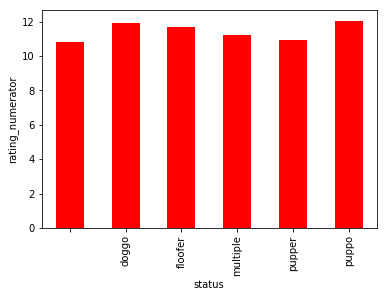

In [99]:
df_master.groupby('status')['rating_numerator'].mean().plot(kind='bar', color='r')
plt.xlabel('status')
plt.ylabel('rating_numerator')

##### 1.2 doggo和puppo的转发数和点赞数显著的高于其他狗狗，每种狗狗获得的点赞数都高于转发数，平均点赞数高于转发数的两倍。

In [100]:
df_master.groupby('status')['favorite_count','retweet_count'].describe()

favorite_count                                                        \
                  count          mean           std     min      25%      50%   
status                                                                          
                 1187.0   8507.920809  10604.841542    81.0  1850.50   4168.0   
doggo              41.0  16347.707317  16448.478717  2581.0  6621.00  10596.0   
floofer            20.0  10726.000000   8876.508471  2255.0  4584.25   8346.0   
multiple           10.0  13292.300000  12821.881029  4511.0  6691.50   9321.5   
pupper            149.0   7677.322148  11874.356834   687.0  2460.00   3296.0   
puppo              21.0  22573.523810  28474.257496  3265.0  6991.00  15329.0   

                             retweet_count                                     \
               75%       max         count         mean           std     min   
status                                                                          
          11170.50   84753.0        1187.0  2424.141533   3111.925786    15.0   
doggo     20201.00   95138.0          41.0  4589.731707   6645.012953   718.0   
floofer   12675.75   33209.0          20.0  3446.000000   3814.060966   494.0   
multiple  14755.25   47679.0          10.0  4121.900000   5340.829138  1260.0   
pupper     7435.00  106481.0         149.0  2362.402685   3685.209147   102.0   
puppo     22964.00  132318.0          21.0  6380.857143  10475.063194   707.0   

                                             
              25%     50%      75%      max  
status                                       
           584.50  1344.0  3111.50  27502.0  
doggo     1953.00  2508.0  4720.00  42045.0  
floofer   1414.75  2630.5  3724.75  18343.0  
multiple  1717.00  2466.0  3473.75  19118.0  
pupper     690.00  1098.0  2422.00  32705.0  
puppo     1695.00  3029.0  5969.00  47958.0

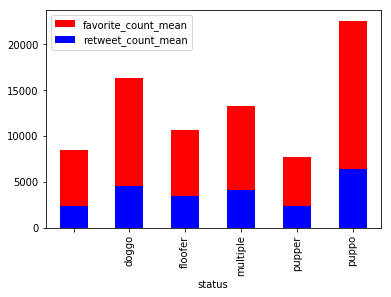

In [101]:
df_master.groupby('status')['favorite_count'].mean().plot(kind='bar', color='r', label = 'favorite_count_mean')
plt.xlabel('status')
plt.legend(loc='upper left')

df_master.groupby('status')['retweet_count'].mean().plot(kind='bar', color='b', label = 'retweet_count_mean')
plt.xlabel('status')
plt.legend(loc='upper left')

##### 1.3 p1预测为狗狗的可信度基本在0.6左右，floofer预测可信度最高，达到0.78。

In [102]:
df_master.groupby('status')['p1_conf'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
,1187.0,0.610460,0.262102,0.044333,0.382161,0.610655,0.853289,0.999956
doggo,41.0,0.597281,0.233709,0.113992,0.442534,0.601712,0.757547,0.999715
floofer,20.0,0.779175,0.266989,0.144012,0.603963,0.947421,0.980852,0.999837
multiple,10.0,0.643497,0.266194,0.321676,0.372596,0.700738,0.862178,0.985876
pupper,149.0,0.661813,0.244274,0.100499,0.441331,0.717776,0.873029,0.999828
puppo,21.0,0.687280,0.218017,0.196015,0.524454,0.660085,0.895529,0.992339


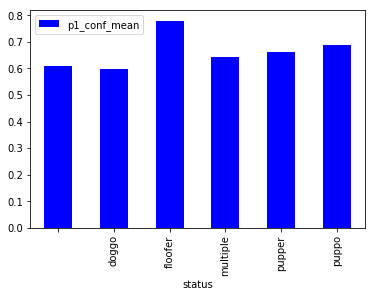

In [103]:
df_master.groupby('status')['p1_conf'].mean().plot(kind='bar', color='b', label = 'p1_conf_mean')
plt.xlabel('status')
plt.legend(loc='upper left')

#### 2、点赞数（favorite_count）、转发数（retweet_count）与评分(rating_numerator)的关系。

##### 2.1 基本上，随着狗狗评分的增高，狗狗获得的点赞数也增多，获得评分为13分的狗狗获得了最多的点赞数。

Text(0,0.5,'favorite_count')

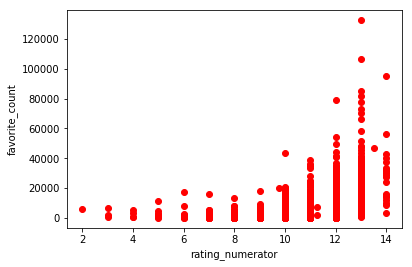

In [104]:
plt.scatter(df_master['rating_numerator'], df_master['favorite_count'],color = 'r')
plt.xlabel('rating_numerator')
plt.ylabel('favorite_count')

##### 2.2 转发数、点赞数和评分的关系拥有一样的变化趋势，随着狗狗评分的增高，狗狗获得的转发数也增多，获得评分为13分的狗狗获得了最多的转发数。

Text(0,0.5,'retweet_count')

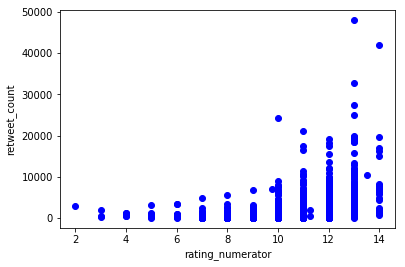

In [105]:
plt.scatter(df_master['rating_numerator'], df_master['retweet_count'],color = 'b')
plt.xlabel('rating_numerator')
plt.ylabel('retweet_count')

##### 2.3 评分数为13.5分的狗狗获得的转发数、点赞数的均值最大，此外，评分数为9.75分的狗狗也获得了不错的转发数和点赞数。

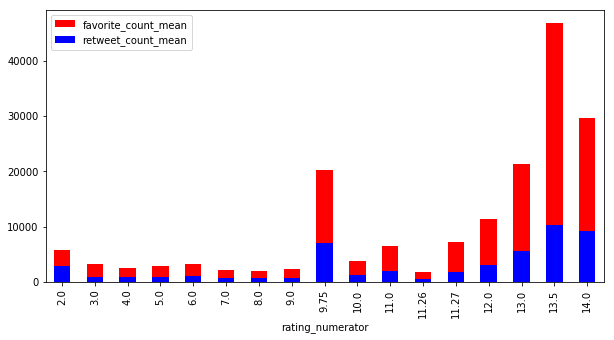

In [106]:
df_master.groupby('rating_numerator')['favorite_count'].mean().plot(kind='bar', color='r', figsize = (10,5), label = 'favorite_count_mean')
plt.xlabel('rating_numerator')
plt.legend(loc='upper left')

df_master.groupby('rating_numerator')['retweet_count'].mean().plot(kind='bar', color='b', figsize = (10,5), label = 'retweet_count_mean')
plt.xlabel('rating_numerator')
plt.legend(loc='upper left')